# 1. Subject Level PCA

In [1]:
import os 
import numpy as np
import pandas as pd
import json
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
from utils import ConcatPCA, PlotTimeSerie, PlotCompoIndividual, TFRmEvents, BbEvents, ExcludSubj
from utils import FREQ_BAND, OUT_PATH

## Select the number of subject

In [11]:
tfr_path = '/users/barbara/Desktop/MIB_iEEG/outs/Data_woBSadjustement'
subj_included = [file.replace('_TFRtrials.p', '') for file in os.listdir(tfr_path) if file[-len('TFRtrials.p'):] == 'TFRtrials.p']
print('Number of subject is ', len(subj_included))

Number of subject is  38


/tmp/ipykernel_10317/992927721.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Old/Correct', 'New/Correct'])


Text(1.1, 2.9, 'DA023')

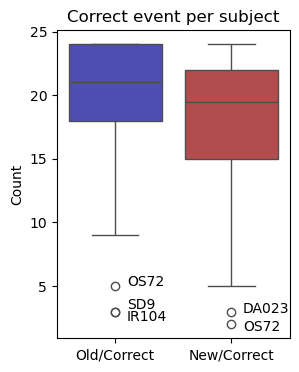

In [12]:
nn_event = {}

for subj in subj_included :   
    info_file = tfr_path + f'/{subj}_info.json'
    with open(info_file) as f:
        info = json.load(f)
        events_index = np.array([int(i) for i in info['event_id']])
    id_ev1 = np.where(events_index == 1)[0]
    id_ev2 = np.where(events_index == 2)[0]
    nn_event[subj] = np.array([len(id_ev1), len(id_ev2)])

fig, ax  =plt.subplots(figsize = (3, 4))
df = pd.DataFrame(nn_event).T
sns.boxplot(df, palette={0 : 'b', 1 : 'r'}, saturation=0.4, ax=ax)
ax.set_xticklabels(['Old/Correct', 'New/Correct'])
ax.set_ylabel('Count')
ax.set_title('Correct event per subject')

idx_smallest_col0 = df.iloc[:, 0].nsmallest(3).index
idx_smallest_col1 = df.iloc[:, 1].nsmallest(2).index

ax.text(s = list(idx_smallest_col0)[0], y= df.loc[list(idx_smallest_col0)[0], 0]-0.7, x= 0.1)
ax.text(s = list(idx_smallest_col0)[1], y= df.loc[list(idx_smallest_col0)[1], 0]+0.2, x= 0.1)
ax.text(s = list(idx_smallest_col0)[2], y= df.loc[list(idx_smallest_col0)[2], 0], x= 0.1)

ax.text(s = list(idx_smallest_col1)[0], y= df.loc[list(idx_smallest_col1)[0], 1]-0.5, x= 1.1)
ax.text(s = list(idx_smallest_col1)[1], y= df.loc[list(idx_smallest_col1)[1], 1]-0.1, x= 1.1)


In [13]:
subj_included = ExcludSubj(subj_included=subj_included, data_path=tfr_path)
print('After check the events the number of subject included is ' , len(subj_included))

After check the events the number of subject included is  30


/tmp/ipykernel_10317/34081397.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Old/Correct', 'New/Correct'])


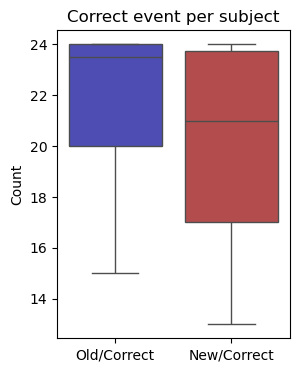

In [15]:
nn_event = {}

for subj in subj_included :   
    info_file = tfr_path + f'/{subj}_info.json'
    with open(info_file) as f:
        info = json.load(f)
        events_index = np.array([int(i) for i in info['event_id']])
    id_ev1 = np.where(events_index == 1)[0]
    id_ev2 = np.where(events_index == 2)[0]
    nn_event[subj] = np.array([len(id_ev1), len(id_ev2)])

fig, ax  =plt.subplots(figsize = (3, 4))
df = pd.DataFrame(nn_event).T
sns.boxplot(df, palette={0 : 'b', 1 : 'r'}, saturation=0.4, ax=ax)
ax.set_xticklabels(['Old/Correct', 'New/Correct'])
ax.set_ylabel('Count')
ax.set_title('Correct event per subject')

idx_smallest_col0 = df.iloc[:, 0].nsmallest(3).index
idx_smallest_col1 = df.iloc[:, 1].nsmallest(2).index

## TFR

In [16]:
event_idx = {0: 'Old', 1:'New'}
color_event = {0: 'b', 1:'r'}

### Concat

In [17]:
# CONCAT
concat_dict_ = {}
concat_dict_corr = {}

for subj in subj_included : 
    TFRm_corr = TFRmEvents(subj, baseline_corr=True, data_path=tfr_path)
    TFRm =TFRmEvents(subj, baseline_corr=False, data_path=tfr_path)
    concat_dict_[subj] = np.concatenate([TFRm[i, :, :,:] for i in [0, 1]], axis = 2)
    concat_dict_corr[subj] = np.concatenate([TFRm_corr[i, :, :,:] for i in [0, 1]], axis = 2)

df_Componants, df_X_transformed = ConcatPCA(concat_dict_, ch_id = False, nb_compo=3)
df_Componants_corr, df_X_transformed_corr = ConcatPCA(concat_dict_corr, ch_id = False, nb_compo=3)


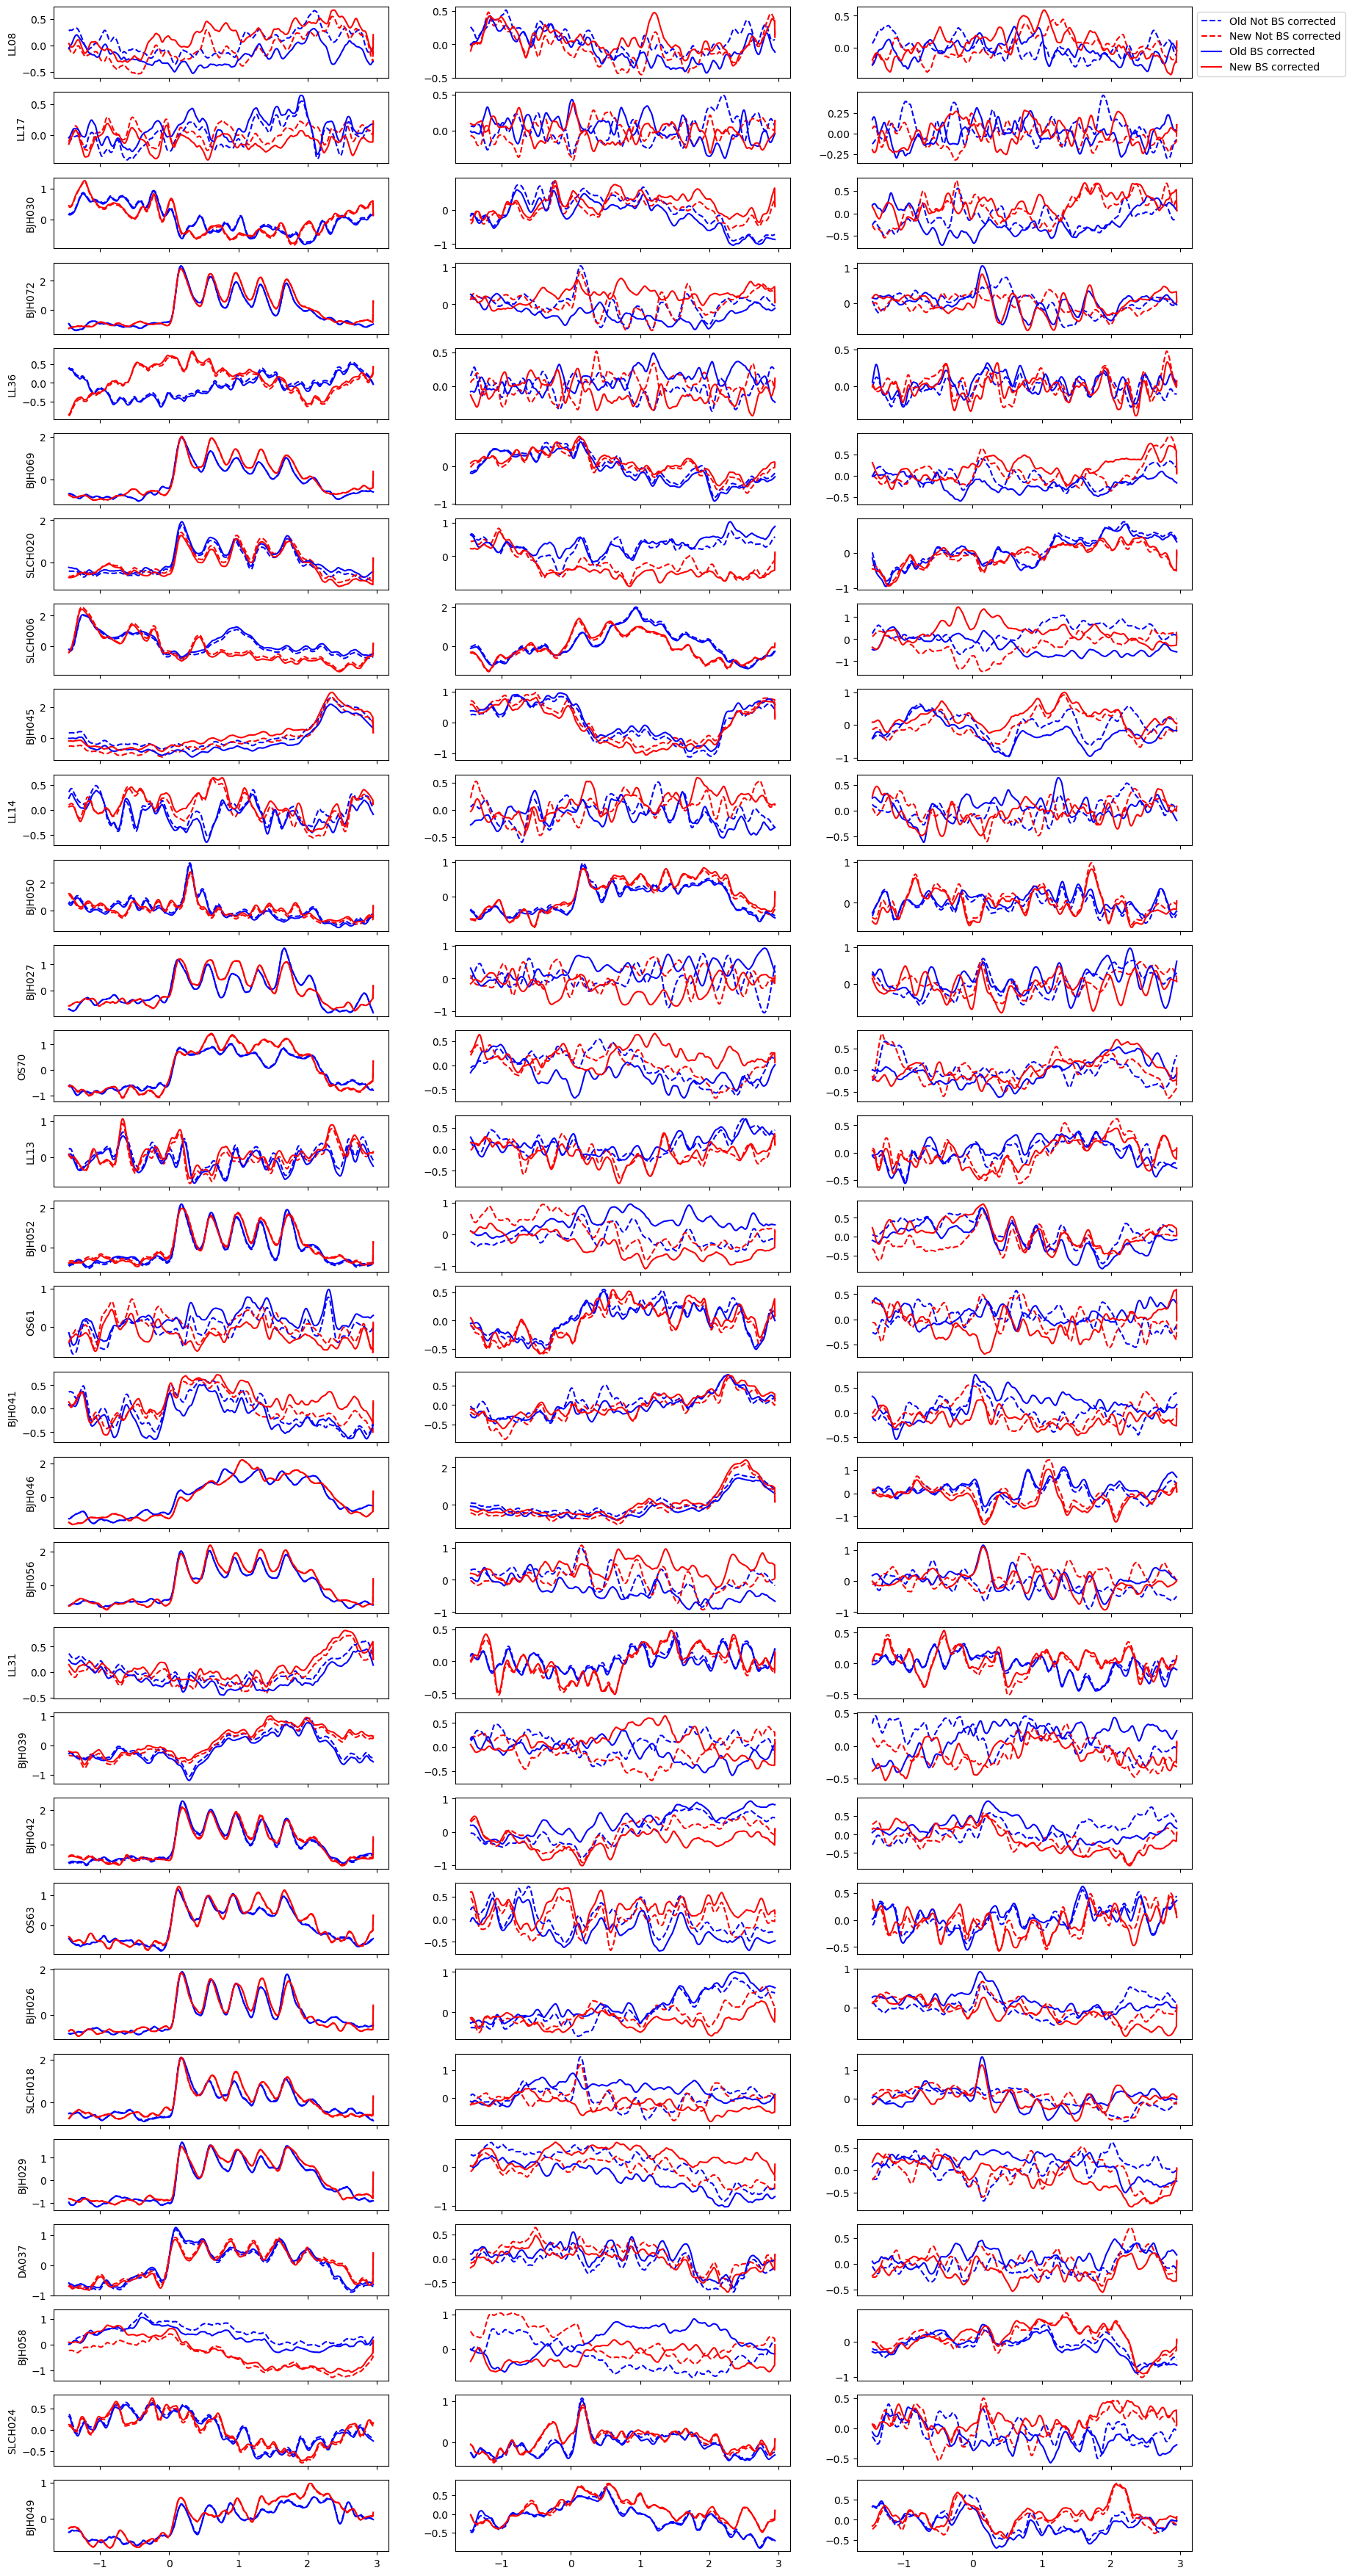

In [24]:
fig, ax= plt.subplots(len(subj_included), 3, figsize = (20, len(subj_included)*1.5), sharex=True)

for i_su, subj in enumerate(subj_included) : 
    with open(tfr_path + f'/{subj}_info.json') as json_data:
        d = json.load(json_data)
        time = d['time_tfr']
        json_data.close()

    data = df_X_transformed.query('subj == @subj and freq == "high_gamma"').drop(columns = ['freq', 'subj', 'compo']).values
    data_corr = df_X_transformed_corr.query('subj == @subj and freq == "high_gamma"').drop(columns = ['freq', 'subj', 'compo']).values
    for i in range(3) : 

        ax[i_su][i].plot(time, data[i, :int(data.shape[1]/2)], label = event_idx[0] + ' Not BS corrected', c= color_event[0], ls='--')
        ax[i_su][i].plot(time, data[i, int(data.shape[1]/2)+1:], label = event_idx[1]+ ' Not BS corrected',  c= color_event[1], ls='--')

        ax[i_su][i].plot(time, data_corr[i, :int(data_corr.shape[1]/2)], label = event_idx[0] + ' BS corrected', c= color_event[0])
        ax[i_su][i].plot(time, data_corr[i, int(data_corr.shape[1]/2)+1:], label = event_idx[1] + ' BS corrected',  c= color_event[1])
    ax[i_su][0].set_ylabel(subj)
ax[0][-1].legend(bbox_to_anchor = (1, 1))


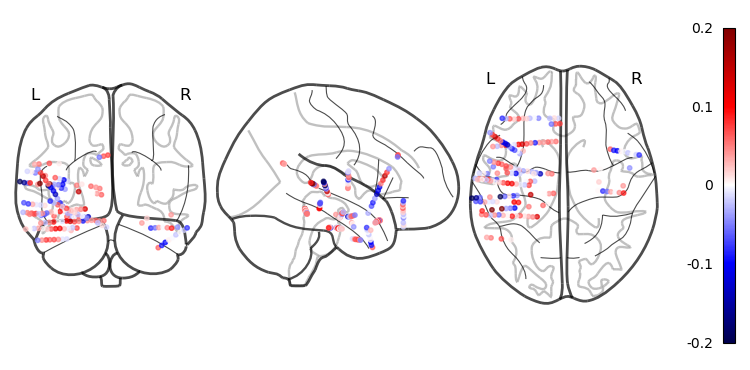

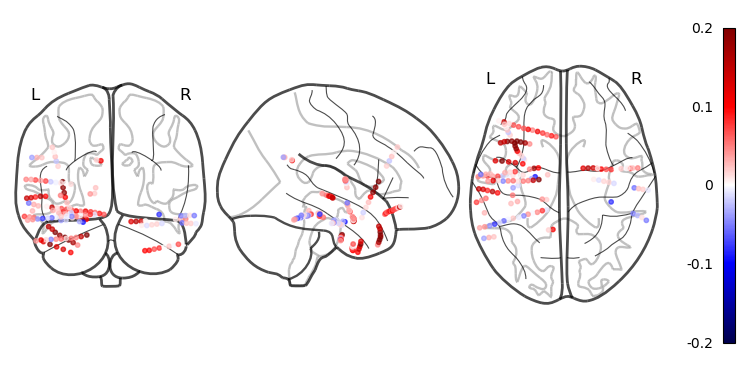

In [18]:
from utils import GetInfo
from nilearn import plotting

subj = 'BJH052' # BJH069 SLCH020 BJH072 BJH052
cor, area, elect, subj_list = GetInfo([subj], data_path=tfr_path)
data = df_Componants_corr[subj].query('freq == "high_gamma"').drop(columns = ['freq', 'compo']).values
fig1 = plotting.plot_markers(node_coords = np.array(cor),  node_size=10, node_values=data[2, :], node_cmap='seismic',display_mode='ortho', node_vmin=-0.2, node_vmax=0.2)


subj = 'BJH027' #'OS70' 'BJH027 BJH029
cor, area, elect, subj_list = GetInfo([subj], data_path=tfr_path)
data = df_Componants_corr[subj].query('freq == "high_gamma"').drop(columns = ['freq', 'compo']).values
fig1 = plotting.plot_markers(node_coords = np.array(cor),  node_size=10, node_values=data[2, :], node_cmap='seismic',display_mode='ortho', node_vmin=-0.2, node_vmax=0.2)



In [31]:
import matplotlib.patches as mpatches

def PlotTimeSerie(subj_list, df_X_transformed, out_path, region='', show=False, save=True, tfr=True)  :    
    for subj in subj_list :  
        # get the time 
        if subj == 'grp' : 
            json_file = OUT_PATH + '/Data/' + [f for f in os.listdir(f'{OUT_PATH}/Data') if '_info.json' in f][0]
        else : 
            json_file = f'{OUT_PATH}/Data/{subj}_info.json'

        with open(json_file) as json_data:
            d = json.load(json_data)
            if tfr:
                time=d['time_tfr']
            else : 
                time=d['time']
        if len(time) > 2000 :     # TODO : fix the bad time in json
            json_file = OUT_PATH + '/Data/' + [f for f in os.listdir(f'{OUT_PATH}/Data') if '_info.json' in f][0] 
            with open(json_file) as json_data:
                d = json.load(json_data)
            if tfr:
                time=d['time_tfr']
            else : 
                time=d['time']
       
        df_subset = df_X_transformed.query('subj == @subj')
        freq_nb = len(np.unique(df_subset.freq.values))
        compo_nb = len(np.unique(df_subset.compo.values))

        if freq_nb == 0 :
            freq_nb =1

        fig, axs = plt.subplots(1 , freq_nb, figsize = (30, 5))
        fig.suptitle('-- ' + subj + ' --')
        color_1 = [plt.cm.Blues(i) for i in np.linspace(0.7, 0.3, compo_nb)] 
        color_2 = [plt.cm.Reds(i) for i in np.linspace(0.7, 0.3, compo_nb)] 

        for band_id, band in enumerate(FREQ_BAND) : 
            for compo_id in range(compo_nb) : 
                df_to_plot = df_subset.query(f'freq == @band')
                the_ax = axs[band_id]

                # event1 
                df_to_plot_1 = df_to_plot.set_index('compo').loc[:, :len(time)-1]
                df_to_plot_1.loc['time', :] = np.array(time)

                the_ax.plot(df_to_plot_1.loc['time', :], df_to_plot_1.loc['compo' + str(compo_id+1), :], label = f'PC{compo_id+1}', color=color_1[compo_id])
                
                # event2
                df_to_plot_2 = df_to_plot.set_index('compo').loc[:, len(time):len(time)*2 -1]                 
                df_to_plot_2.loc['time', :] = time
                the_ax.plot(df_to_plot_2.loc['time', :], df_to_plot_2.loc['compo' + str(compo_id+1), :], label = f'PC{compo_id+1}', color=color_2[compo_id])
            
                the_ax.set_xlabel('Time (s)')
                the_ax.set_title(band)

                if band_id == len(FREQ_BAND)-1 :
                    line_handles, line_labels = the_ax.get_legend_handles_labels()

                    cmap_patches = [mpatches.Patch(color=color_1[0], label='Old / Correct (Blues)'), 
                                    mpatches.Patch(color=color_2[0], label='New / Correct (Reds)')]
                    
                    handles = line_handles + cmap_patches
                    labels = line_labels + [p.get_label() for p in cmap_patches]

                    the_ax.legend(handles, labels, loc='upper left', frameon=True, bbox_to_anchor = (1.05, 0.7))

        if save : fig.savefig(f'{out_path}/{subj}_{region}_PCs.png')
        if show : plt.plot()
        else  : plt.close()

In [32]:
PlotTimeSerie(list(concat_dict_.keys()), df_X_transformed, out_path = f'{OUT_PATH}/subjPCA/TFR/Concat', save=True, show=False)

In [33]:
for subj in subj_included : 
    try : 
        PlotCompoIndividual(subj, df_Componants, save=True, out_path=f'{OUT_PATH}/subjPCA/TFR/Concat')
    except Exception as e : 
        print(subj)
        print(e)

In [ ]:
# For Decoding save X_transform give more componants
_, df_X_transformed = ConcatPCA(concat_dict_, ch_id = False, nb_compo=3)
df_X_transformed.to_csv(f'{OUT_PATH}/subjPCA/TFR/subj_Xtrans_PCA3_concat.csv')

### Mean

In [ ]:
# MEAN 
mean_dict_ = {}
for subj in subj_included : 
    TFRm =TFRmEvents(subj)
    mean_dict_[subj] = TFRm.mean(0)

df_Componants, df_X_transformed = ConcatPCA(mean_dict_, ch_id = False, nb_compo=2)

# PROJECT BACK 
df_list = []

for subj in subj_included : 
    TFRm = TFRmEvents(subj)
    for i_b, band in enumerate(FREQ_BAND) : 
        weights =df_Componants[subj].query('freq == @band').drop(columns = ['freq','compo'])

        data1 = weights @ TFRm[0,:, i_b, :]
        data2 = weights @ TFRm[1,:, i_b, :]
        
        df= pd.DataFrame(np.concat([data1, data2], axis = 1))
        df['compo'] = ['compo' + str(i+1) for i in range(len(df))]
        df['subj'] = subj
        df['freq'] = band
        df_list.append(df)

df_X_transformed_applied = pd.concat(df_list)
PlotTimeSerie(list(mean_dict_.keys()), df_X_transformed_applied, out_path = f'{OUT_PATH}/subjPCA/TFR/Mean', save=True, show=False)

for subj in subj_included : 
    try : 
        PlotCompoIndividual(subj, df_Componants, save=True, out_path=f'{OUT_PATH}/subjPCA/TFR/Mean')
    except Exception as e : 
        print(subj)
        print(e)

df_Componants, df_X_transformed = ConcatPCA(mean_dict_, ch_id = False, nb_compo=3)

# PROJECT BACK 
df_list = []

for subj in subj_included : 
    TFRm = TFRmEvents(subj)
    for i_b, band in enumerate(FREQ_BAND) : 
        weights =df_Componants[subj].query('freq == @band').drop(columns = ['freq','compo'])

        data1 = weights @ TFRm[0,:, i_b, :]
        data2 = weights @ TFRm[1,:, i_b, :]
        
        df= pd.DataFrame(np.concat([data1, data2], axis = 1))
        df['compo'] = ['compo' + str(i+1) for i in range(len(df))]
        df['subj'] = subj
        df['freq'] = band
        df_list.append(df)

df_X_transformed_applied = pd.concat(df_list)
df_X_transformed_applied.to_csv(f'{OUT_PATH}/subjPCA/TFR/subj_Xtrans_PCA3_mean.csv')

## BROAD BAND

In [20]:
epoch_path = OUT_PATH + '/Data'
subj_included = [file.replace('_epochs.p', '') for file in os.listdir(epoch_path) if file[-len('epochs.p'):] == 'epochs.p']
subj_included = ExcludSubj(subj_included=subj_included)

print('Number of subject is ', len(subj_included))

Number of subject is  30


In [21]:
# subj level
nb_compo = 3
X_trans_list = []

for subj in subj_included: 
    print(subj)
    epochs = BbEvents(subj)
    # compute the mean accross the condi fit the PCA get compo + exp var
    mean_data= epochs.mean(0)
    pca = PCA(nb_compo)
    pca.fit(mean_data.T)

    df_Compo = pd.DataFrame(pca.components_)
    df_Compo['compo'] = ['compo'  +str(i+1) for i in range(nb_compo)]
    df_Compo['freq'] = ['broadband']*nb_compo 

    ev = pca.explained_variance_ratio_

    # apply the PCA to individual condi
    data_transfrom = np.zeros((2, pca.components_.shape[0], epochs.shape[2])) # condi, compo, time_points
    data_transfrom[0, :,:] = pca.transform(epochs[0, :,:].T).T
    data_transfrom[1, :,:] = pca.transform(epochs[1, :,:].T).T

    df = pd.DataFrame(np.concat([data_transfrom[0, :, :], data_transfrom[1, :, :]], axis=1))
    df['subj'] = subj
    df['compo'] = ['compo'  +str(i+1) for i in range(nb_compo)]
    df['freq'] = ['broadband']*nb_compo 

    X_trans_list.append(df)
    
    try : 
        PlotCompoIndividual(subj, df_Componants={subj : df_Compo},nb_compo = nb_compo,freq_band=['broadband'], out_path= OUT_PATH + '/subjPCA/Broadband')
    except : 
        print('plotting failled')
    # plot the time serie 
    fig, ax = plt.subplots(1,nb_compo, figsize = (14, 4), sharey=True)
    fig.suptitle(f'{subj} PCs (Broadband)')

    info_file = f'{OUT_PATH}/Data/{subj}_info.json'
    with open(info_file) as f:
        info = json.load(f)
        time = info['time_epoch']

    for i in range(nb_compo) : 
        ax[i].plot(time, data_transfrom[0, i,:], c = 'blue', label='old/correct', alpha = 0.7)
        ax[i].plot(time, data_transfrom[1, i,:], c = 'red', label='new/correct', alpha = 0.7)
        ax[i].set_title(f'PC {str(i+1)} --  ev : {np.round(ev[i], 2)}')
        
    ax[i].legend()
    plt.savefig(OUT_PATH + f'/subjPCA/Broadband/{subj}_TimeSeries.png')
    plt.close()

# save data transform
df_X_transform = pd.concat(X_trans_list)
df_X_transform.to_csv(f'{OUT_PATH}/subjPCA/Broadband/subj_Xtrans_PCA{nb_compo}.csv')


LL08
LL17
BJH072
LL36
LL14
BJH050
LL13
OS61
BJH041
LL31
BJH039
BJH042
OS63
BJH026
SLCH018
DA037
SLCH024
BJH049
BJH030
BJH069
SLCH020
SLCH006
BJH045
BJH027
OS70
BJH052
BJH046
BJH056
BJH029
BJH058
